In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Meiryo'

In [2]:
# CSVファイルを読み込み
df = pd.read_csv('./dataset_cur_train.csv',index_col = 0)
display(df.head(2))
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['red_diff'])
train_df.shape, test_df.shape

,red_diff,remain_ends,last_stone_is_red,red_postion,filepath
8,1.0,0,True,3.0,./dataset_o\ECC2023_ResultsBook_Women_A-Divisi...
0,2.0,8,True,0.0,./dataset_o\ECC2021_ResultsBook_Men_A-Division...


((11959, 5), (2990, 5))

In [3]:
len(train_df['red_diff'].unique() ),len(test_df['red_diff'].unique())

(11, 11)

In [13]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision
from torchvision import datasets, models

from PIL import Image
import os

In [14]:
class ImgValueDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None):
        self.img_pathList  = df['filepath'].to_list()
        self.labels  = pd.get_dummies(df['red_diff']).values
        self.val_list  = df[['remain_ends','last_stone_is_red','red_postion']].astype(np.float16).values

        self.transform = transform
    
    def __len__(self):  
        return len( self.img_pathList )
    
    def __getitem__(self, index):
        # 画像をPILとして読み込む
        #print(index)
        src = self.img_pathList[index]
        #print(os.path.exists(src))
        image = Image.open(src)
        image = image.convert("RGB") 
        #numpy_img = np.asarray(image, np.float32) / 255.0
        #tensor_img = np.expand_dims(image, axis=0) # このままだとNWHCの形式
        
        label = self.labels[index]
        extend = self.val_list[index]                         
        if self.transform is not None:
            ##print('use transform')
            image = self.transform(image)
        ## 次元を足してやってっそこに追加データをぶっこむ
        extend_tensor = np.full((224,224),255)
        extend_tensor[1][0] = extend[0]
        extend_tensor[1][1] = extend[1]
        extend_tensor[1][2] = extend[2]
        extend_tensor = torch.Tensor(extend_tensor)
        extend_tensor = extend_tensor.unsqueeze(0)
        out = torch.cat([image, extend_tensor], dim=0)
        return out,label 

In [15]:
target_size = 224
transform = transforms.Compose([
    transforms.Pad(( 240 // 2, 0), fill=0, padding_mode='constant'),  # 左右に余白を追加
    transforms.Resize(target_size),
    transforms.CenterCrop(target_size),
    transforms.ToTensor()
])
myDataset = ImgValueDataset( train_df ,transform=transform)

In [16]:
inputs, classes = next(iter(myDataset))
inputs.shape

torch.Size([4, 224, 224])

In [17]:
image = inputs[:3]
image.shape

torch.Size([3, 224, 224])

In [18]:
values = inputs[3:]
print(values.shape , values)

torch.Size([1, 224, 224]) tensor([[[255., 255., 255.,  ..., 255., 255., 255.],
         [  8.,   0.,   0.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         ...,
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.]]])


,red_diff,remain_ends,last_stone_is_red,red_postion,filepath
8,1.0,0,True,3.0,./dataset_o\ECC2023_ResultsBook_Women_A-Divisi...
0,2.0,8,True,0.0,./dataset_o\ECC2021_ResultsBook_Men_A-Division...


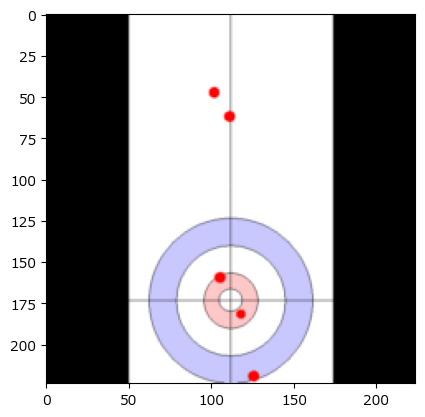

In [38]:
im = torchvision.transforms.functional.to_pil_image(image)
plt.imshow(im)
display(df.head(2))

## データローダに仕立てる

In [39]:
import torch
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms = True
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
target_size = 224
transform = transforms.Compose([
    transforms.Pad(( 240 // 2, 0), fill=0, padding_mode='constant'),  # 左右に余白を追加
    transforms.Resize(target_size),
    transforms.CenterCrop(target_size),
    transforms.ToTensor()
])
train_dataset = ImgValueDataset( train_df ,transform=transform)
test_dataset = ImgValueDataset( test_df ,transform=transform)

In [22]:

batch_size = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, drop_last=True)

In [23]:
a,b = next(iter(train_loader))
a.shape,b

(torch.Size([10, 4, 224, 224]),
 tensor([[False, False, False, False, False, False, False, False, False,  True,
          False],
         [False, False, False, False, False,  True, False, False, False, False,
          False],
         [False, False, False, False, False, False, False, False,  True, False,
          False],
         [False, False, False, False,  True, False, False, False, False, False,
          False],
         [False, False, False, False,  True, False, False, False, False, False,
          False],
         [False, False, False, False, False, False,  True, False, False, False,
          False],
         [False, False, False,  True, False, False, False, False, False, False,
          False],
         [False, False, False, False,  True, False, False, False, False, False,
          False],
         [False, False, False, False,  True, False, False, False, False, False,
          False],
         [False, False, False, False,  True, False, False, False, False, False,
      

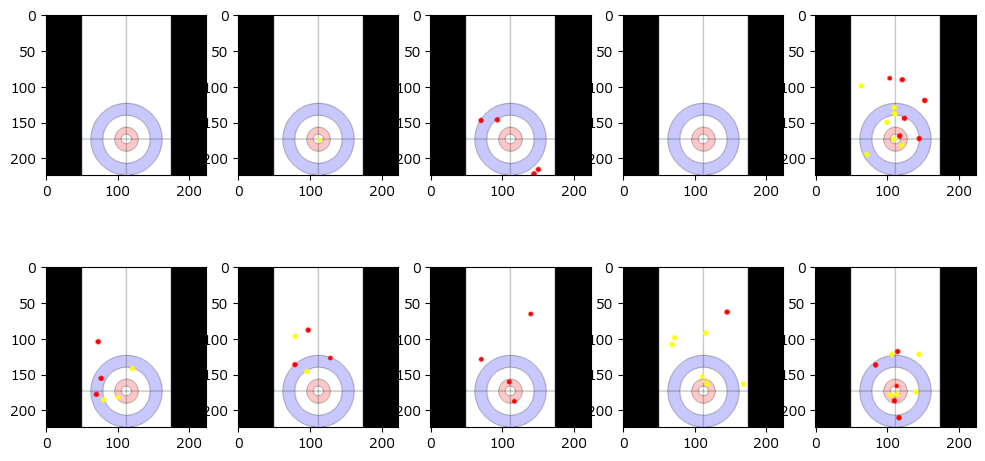

In [24]:
## イメージ分離
images = a[:,:3]
k ,_,_,_ = images.shape
imlist = []
for i in range(k):
    data = images[i]
    im = torchvision.transforms.functional.to_pil_image(data)
    imlist.append(im)
n = len(imlist)
fig , axs = plt.subplots(2, n//2,figsize=(12,6))
axs = axs.flatten()
for i in range(n):
    axs[i].imshow(imlist[i])

In [29]:
## 値分離
values = a[:,3:]
k ,_,_,_ = images.shape
imlist = []
for i in range(k):
    data = values[i]
    print(data[0][1][0:3])

tensor([ 4.,  1., -1.])
tensor([8., 1., 0.])
tensor([3., 1., 2.])
tensor([ 1.,  1., -1.])
tensor([6., 0., 0.])
tensor([ 1.,  1., -2.])
tensor([3., 0., 1.])
tensor([ 5.,  1., -2.])
tensor([1., 1., 1.])
tensor([6., 0., 1.])


Netを組む

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [31]:
# CNNモデルの定義
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        viewCnt = (32 * 56 * 56)
        
        self.fc1 = nn.Linear(viewCnt+3, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        images = x[:,:3]
        values = x[:,3:]
        images = self.pool(F.relu(self.conv1(images)))
        images = self.pool(F.relu(self.conv2(images)))
        images = images.view(-1, 32 * 56 * 56)
        ## -- 結合します
        params = values[:,0,1,0:3]
        packedData = torch.cat([images,params],1)
        #print(images.shape,values.shape,packedData.shape)
        packedData = F.relu(self.fc1(packedData))
        packedData = self.fc2(packedData)
        packedData
        return packedData

In [32]:
num_classes = len(train_df['red_diff'].unique() )
cnn_model = SimpleCNN(num_classes=num_classes)

In [33]:
cnn_model

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100355, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=11, bias=True)
)

In [34]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, drop_last=True)

imput , label = next(iter(train_loader))
imput.shape
num_classes = len(train_df['red_diff'].unique() )
cnn_model = SimpleCNN(num_classes=num_classes)
cnn_model(imput)

tensor([[-0.0629, -0.0099, -0.0288, -0.1246, -0.0255, -0.0324, -0.0133,  0.0301,
          0.0142,  0.0492,  0.0062],
        [-0.0600, -0.0100, -0.0293, -0.1284, -0.0322, -0.0337, -0.0148,  0.0258,
          0.0142,  0.0449,  0.0131],
        [-0.0572, -0.0144, -0.0251, -0.1279, -0.0251, -0.0321, -0.0142,  0.0294,
          0.0156,  0.0493,  0.0108],
        [-0.0599, -0.0115, -0.0311, -0.1261, -0.0298, -0.0324, -0.0161,  0.0301,
          0.0113,  0.0499,  0.0088],
        [-0.0576, -0.0070, -0.0248, -0.1304, -0.0348, -0.0351, -0.0124,  0.0253,
          0.0118,  0.0438,  0.0085],
        [-0.0626, -0.0106, -0.0296, -0.1247, -0.0254, -0.0330, -0.0121,  0.0310,
          0.0110,  0.0500,  0.0075],
        [-0.0489, -0.0116, -0.0216, -0.1267, -0.0393, -0.0331, -0.0168,  0.0281,
          0.0078,  0.0454,  0.0075],
        [-0.0587, -0.0135, -0.0261, -0.1262, -0.0280, -0.0347, -0.0134,  0.0295,
          0.0116,  0.0508,  0.0093],
        [-0.0652, -0.0085, -0.0309, -0.1244, -0.0246, -0

In [35]:
values = a[:,3:]
j = values[:,0,1,0:3]
dmyimg = np.full((10,100352),255)
qimage = torch.Tensor(dmyimg)
qimage.shape
torch.cat([qimage,j],1)

tensor([[255., 255., 255.,  ...,   4.,   1.,  -1.],
        [255., 255., 255.,  ...,   8.,   1.,   0.],
        [255., 255., 255.,  ...,   3.,   1.,   2.],
        ...,
        [255., 255., 255.,  ...,   5.,   1.,  -2.],
        [255., 255., 255.,  ...,   1.,   1.,   1.],
        [255., 255., 255.,  ...,   6.,   0.,   1.]])

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [37]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, drop_last=True)
# 学習
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(train_df['red_diff'].unique() )
criterion = nn.CrossEntropyLoss()
model_gpu = SimpleCNN(num_classes=num_classes).to(device)
optimizer_gpu =  optim.Adam(model_gpu.parameters(), lr=0.001)

train_loss_value=[]      #trainingのlossを保持するlist
train_acc_value=[]       #trainingのaccuracyを保持するlist
test_loss_value=[]       #testのlossを保持するlist
test_acc_value=[]        #testのaccuracyを保持するlist 

num_epochs = 100
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels_float = labels.float().to(device)
        optimizer.zero_grad()
        outputs = model_gpu(images)
        loss = criterion(outputs, labels_float)
        loss.backward()
        optimizer_gpu.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


Epoch [1/100], Loss: 2.1135759353637695
Epoch [2/100], Loss: 2.538886547088623
Epoch [3/100], Loss: 2.085237503051758
Epoch [4/100], Loss: 1.7296082973480225
Epoch [5/100], Loss: 1.8146506547927856
Epoch [6/100], Loss: 1.9103493690490723
Epoch [7/100], Loss: 1.7750999927520752
Epoch [8/100], Loss: 1.756265640258789
Epoch [9/100], Loss: 1.9606823921203613
Epoch [10/100], Loss: 1.8994380235671997
Epoch [11/100], Loss: 2.3875863552093506
Epoch [12/100], Loss: 2.183795690536499
Epoch [13/100], Loss: 1.8763703107833862
Epoch [14/100], Loss: 1.800591230392456
Epoch [15/100], Loss: 2.066704273223877
Epoch [16/100], Loss: 1.9036760330200195
Epoch [17/100], Loss: 2.0061802864074707
Epoch [18/100], Loss: 2.110422372817993
Epoch [19/100], Loss: 1.937135934829712
Epoch [20/100], Loss: 1.8962528705596924
Epoch [21/100], Loss: 1.8873975276947021
Epoch [22/100], Loss: 1.7363145351409912
Epoch [23/100], Loss: 1.834534764289856
Epoch [24/100], Loss: 1.7717125415802002
Epoch [25/100], Loss: 2.5638089179

In [632]:
Epoch [1/5], Loss: 2.3228600025177
Epoch [2/5], Loss: 1.8527653217315674
Epoch [3/5], Loss: 2.0662903785705566
Epoch [4/5], Loss: 2.3889870643615723
Epoch [5/5], Loss: 1.7179456949234009

SyntaxError: only single target (not tuple) can be annotated (3721656434.py, line 1)

In [533]:
one_hot = F.one_hot(labels_int), num_classes=num_classes)

SyntaxError: cannot assign to function call (1370988544.py, line 1)

In [534]:
one_hot = F.one_hot(labels_int), num_classes=num_classes)

SyntaxError: cannot assign to function call (1370988544.py, line 1)

In [539]:
F.one_hot(labels_int,num_classes=num_classes)

RuntimeError: Class values must be non-negative.

In [562]:
labels_int

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [543]:
pd.get_dummies(df['red_diff']).values

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])